In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Parsers as P, Utilities as U
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import os

# TLS description of optical absorption in GaAs 

We try to reproduce the results of the optical absorption of GaAs obtained with Yambo using the physics of the TLS.

## TLS analysis of a single transition at 1.5 eV with a single gaussian pulse

The parameters common in the yambo and in the TLS analysis are

In [97]:
fwhm = 100 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
de_cv = 1.5 # the band gap in eV
intensity = 23758 # 23758 # # 95032 kW/cm2
energy = 1.52 # 1.52 # 1.5 # eV energy of the pulse
NETime = 500 # fs
ntimes = 10001 # as in the rt simulations (for the green function)

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
omega = energy/h_red # angular frequency of the pulse

In [98]:
ref_run_dir = 'PHOTON_ECO/RT_singlek1.5_nosym'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi'
ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune'

In [99]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.external_field
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.carriers
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.polarization
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.current
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/ndb.RT_G_PAR


In [100]:
# ref_results.get_info()

In [101]:
# We build the reference quantities to compare with the TLS results

ref_time = ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_carriers = ref_results.data['carriers']['dne']

green = ref_results.RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
u_ref = P.buildBlochVectors(dm)

In [102]:
u_ref[:,0,0]

array([ 0., -0.,  1.])

In [103]:
dft = ref_results.dft
dft.get_evals(set_scissor=scissor)

Apply a scissor of 0.9548 eV


array([[-1.29828944e+01, -8.31392810e-02, -2.68312675e-03,
         0.00000000e+00,  1.50000196e+00,  4.72523418e+00,
         4.73080659e+00,  4.73342509e+00]])

We define the array with the $x$ component of the transition dipoles

In [104]:
x_dipole = ref_results.dipoles.r_dipole(0)
x_dipole

array([[[0.         +0.j        , 6.16043462+18.39722623j],
        [6.16043462-18.39722623j, 0.         +0.j        ]]])

Note that the $x_{01}$ component that is the equivalent of the $\mu_{12}$ dipole (with opposite sign!)  defined in theory of the TLS.

We compute the field amplitude and the Rabi coupling associated to a given field intensity.

In [105]:
kref = 0 # we use the (only) k point of this computation
mu12_ref = -x_dipole[kref,0,1]
pars = TLS.pulseParametersFromIntensity(mu12_ref,intensity,fwhm=fwhm)
pars

time unit: fs
the width parameter of the pulse is 42.466090014400955 fs
Rabi coupling (fs^-1): (-0.004685618562658017-0.013992906355431267j)
Rabi coupling (module) (fs^-1): 0.014756573097660382
field amplitude (V/m): 9460633.581454257
pulse area : 1.5707885382285562


{'Omega0': (-0.004685618562658017-0.013992906355431267j),
 'Omega0_abs': 0.014756573097660382,
 'field_amplitude': 9460633.581454257,
 'theta': 1.5707885382285562}

In [106]:
time = np.linspace(0,NETime,ntimes)

We build the gaussian pulse used as input of the TLS and check thati its amplitude matches the
one of the yambo Ex field

In [107]:
pulse = G.gaussianPulse(time,energy=energy,amplitude=pars['field_amplitude'],fwhm=fwhm)

time unit: fs - energy unit: eV
period of the oscillations 2.7208340113370535 fs
width of the pulse 42.466090014400955 fs
fwhm of the pulse 100 fs


(0.0, 200.0)

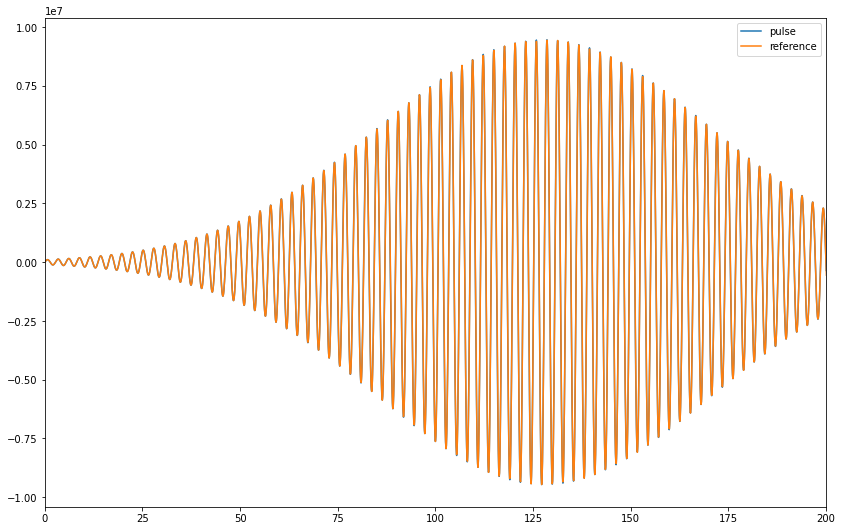

In [108]:
plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(0,200)

In [109]:
Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm,envelope_only=True,verbose=False)

In [110]:
uprime0 = np.array([0.,0.,1.])

In [111]:
delta = energy - de_cv # in eV
delta_fsm1 = delta/h_red # in fs^-1
delta_fsm1

0.030385348955306226

In [112]:
uprime = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12_ref,delta=delta_fsm1)

We plot the Bloch vector computed with the TLS equations in the rotating frame

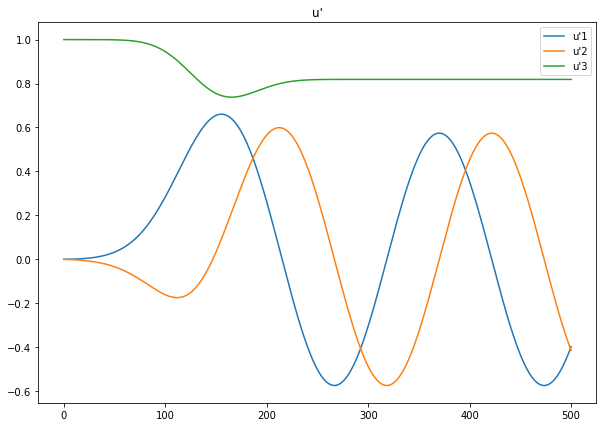

In [113]:
plt.figure(figsize=(10,7))
plt.plot(time,uprime[0],label="u'1")
plt.plot(time,uprime[1],label="u'2")
plt.plot(time,uprime[2],label="u'3")
plt.title("u'")
plt.legend()

Now we move in the original frame and we compare the results with the yambo computation.

In [114]:
u = TLS.convertToRotatingFrame(omega,time,uprime,invert=True)

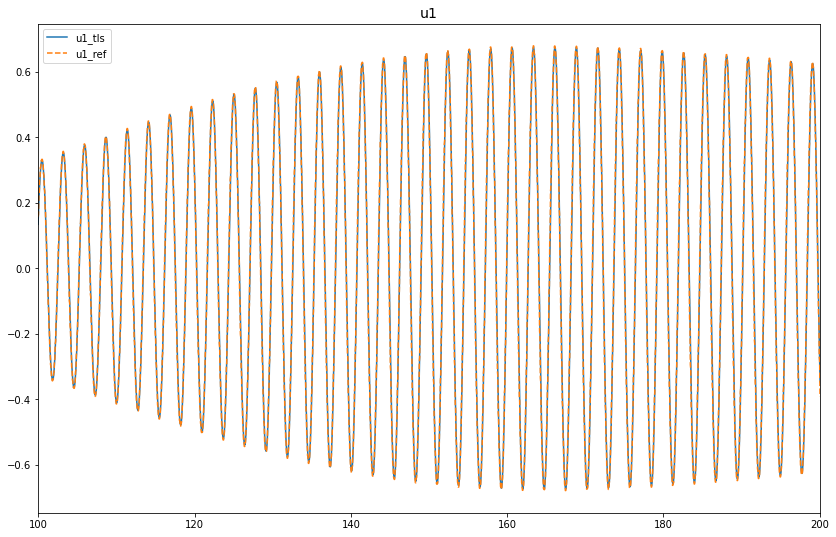

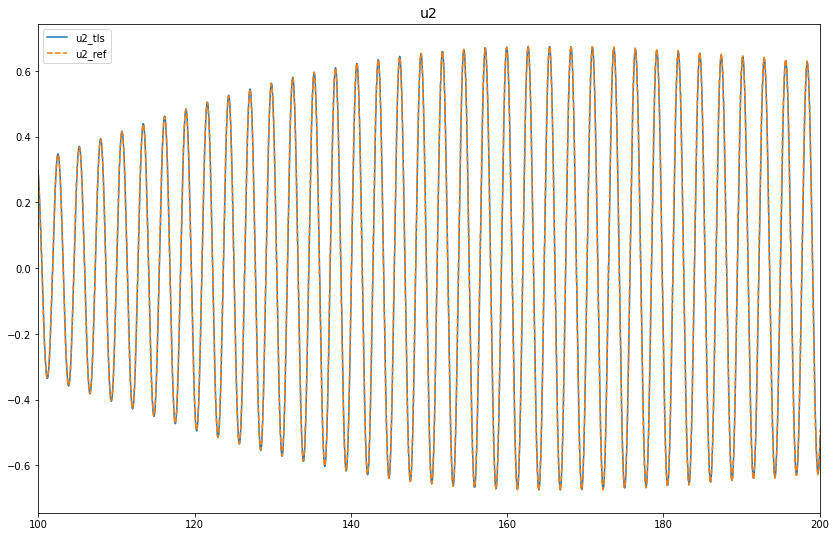

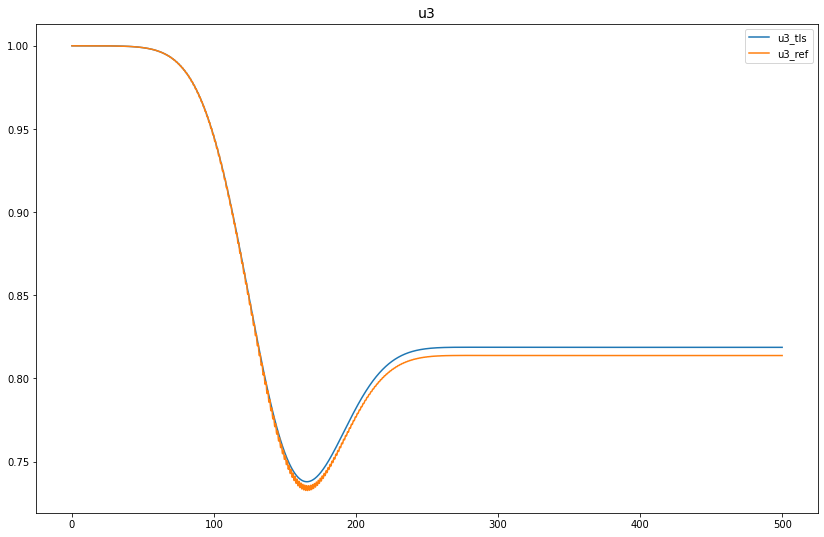

In [115]:
plt.figure(figsize=(14,9))
plt.plot(time,u[0],label='u1_tls')
plt.plot(time,u_ref[0,:,0],linestyle='--',label='u1_ref')
plt.title('u1',size=14)
plt.xlim(100,200)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,u[1],label='u2_tls')
plt.plot(time,u_ref[1,:,0],linestyle='--',label='u2_ref')
plt.title('u2',size=14)
plt.xlim(100,200)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.title('u3',size=14)
plt.plot(time,u[2],label='u3_tls')
plt.plot(time,u_ref[2],label='u3_ref')
plt.legend()
plt.show()

The bloch vector built with the TLS is (almost) identical to the one extracted from the yambo computation for a single transition.

Note that the condition $\mu_{12} = - x_{12}$ is needed to reproduce the
results of the Yambo computation. If we don't the sign of $u_1$ and $u_2$ is wrong!.

## TLS analysis of a single transition at 1.5 eV with a double gaussian pulse

The parameters common in the yambo and in the TLS analysis are

In [116]:
fwhm = 100 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
de_cv = 1.5 # the band gap in eV
int1 = 23758 # 23758 # # 95032 kW/cm2
int2 = 95032 # 23758 # # 95032 kW/cm2
energy = 1.5 # eV 
NETime = 2000 # fs
ntimes = 40001 # as in the rt simulations (for the green function)

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
omega = energy/h_red # angular frequency of the pulse

# set the tstart of the second pulse as in the RT simulation
h = C.Planck_ev_ps*1e3
period = h/energy # in fs
tstart = period*218 #363

In [117]:
ref_run_dir = 'PHOTON_ECO/RT_singlek1.5_nosym'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi2'
ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi'

In [118]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.current
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.external_field
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.carriers
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/o-pi2-pi.polarization
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2-pi/ndb.RT_G_PAR


In [119]:
ref_results.get_info()

YamboOutputParser variables structure
suffix current with dict_keys(['col0', 'col1', 'col2', 'col3'])
suffix external_field with dict_keys(['time', 'Ex_Re', 'Ey_Re', 'Ez_Re', 'Ex_Im', 'Ey_Im', 'Ez_Im', 'Intensity', 'Fluence'])
suffix carriers with dict_keys(['time', 'dnhmne', 'dnh', 'dne'])
suffix polarization with dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])
 
YamboDipolesParser variables structure
dip_ir shape (1, 2, 2, 3, 2)
dip_p shape (1, 2, 2, 3, 2)
dip_v shape (1, 2, 2, 3, 2)
dip_spin shape (1,)
 
YamboDftParser variables structure
number of k points 1
number of bands 8
spin degeneration 1
 
YamboRTGlesserParser variables structure
Gless shape (40001, 1, 2, 2, 2)


In [120]:
# We build the reference quantities to compare with the TLS results

ref_time = ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_carriers = ref_results.data['carriers']['dne']

green = ref_results.RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
u_ref = P.buildBlochVectors(dm)

We define the array with the $x$ component of the transition dipoles

In [121]:
x_dipole = ref_results.dipoles.r_dipole(0)
x_dipole[0]

array([[0.         +0.j        , 6.16043462+18.39722623j],
       [6.16043462-18.39722623j, 0.         +0.j        ]])

Note that the $x_{01}$ component that is the equivalent of the $\mu_{12}$ dipole (with opposite sign!)  defined in theory of the TLS.

We compute the field amplitude and the Rabi coupling associated to a given field intensity

In [122]:
kref = 0 # we use the (only) k point of this computation
mu12_ref = -x_dipole[kref,0,1]
pars1 = TLS.pulseParametersFromIntensity(mu12_ref,int1,fwhm=fwhm)
pars2 = TLS.pulseParametersFromIntensity(mu12_ref,int2,fwhm=fwhm)
#pars1

time unit: fs
the width parameter of the pulse is 42.466090014400955 fs
Rabi coupling (fs^-1): (-0.004685618562658017-0.013992906355431267j)
Rabi coupling (module) (fs^-1): 0.014756573097660382
field amplitude (V/m): 9460633.581454257
pulse area : 1.5707885382285562
time unit: fs
the width parameter of the pulse is 42.466090014400955 fs
Rabi coupling (fs^-1): (-0.009371237125316035-0.027985812710862534j)
Rabi coupling (module) (fs^-1): 0.029513146195320764
field amplitude (V/m): 18921267.162908513
pulse area : 3.1415770764571125


In [123]:
time = np.linspace(0,NETime,ntimes)

We build the gaussian pulse used as input of the TLS and check that its amplitude matches the
one of the yambo Ex field

In [124]:
pulse = G.doubleGaussianPulse(time,energy=energy,amplitude1=pars1['field_amplitude'],fwhm1=fwhm,
                amplitude2=pars2['field_amplitude'],fwhm2=fwhm,t_start2=tstart)

time unit: fs - energy unit: eV
period of the oscillations 2.757111798154881 fs
width of the first pulse 42.466090014400955 fs
fwhm of the first pulse 100 fs
width of the second pulse 42.466090014400955 fs
fwhm of the second pulse 100 fs


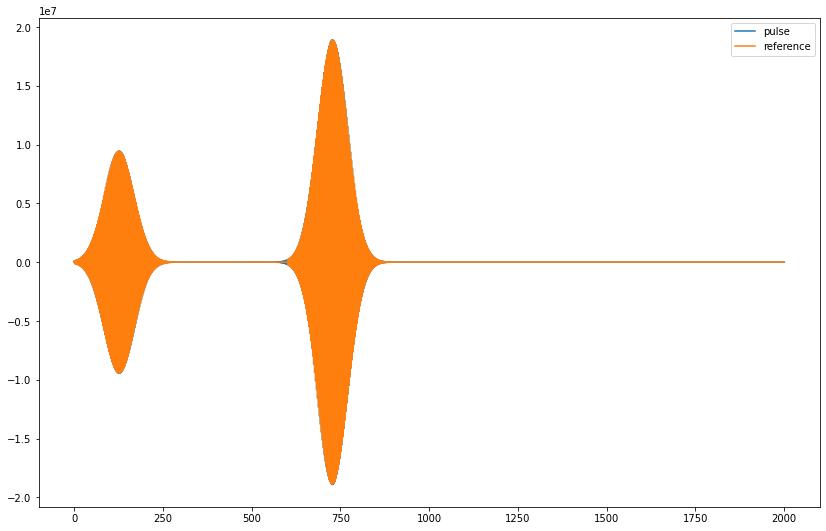

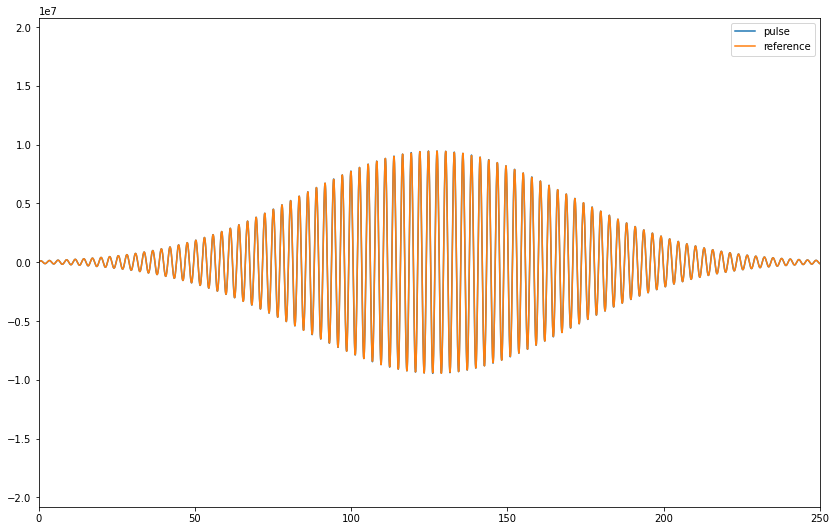

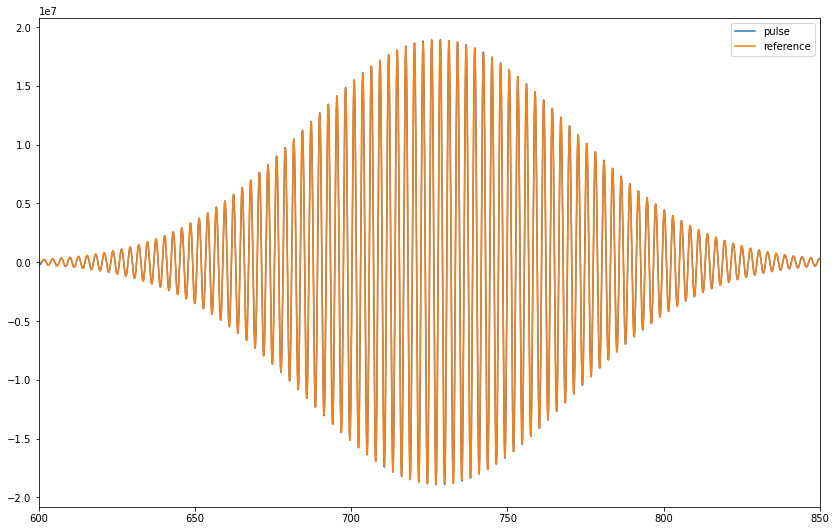

In [125]:
plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(0,250)
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(600,850)
plt.show()

In [126]:
Omega = lambda t : G.doubleGaussianPulse(t,energy=energy,amplitude1=pars1['Omega0_abs'],fwhm1=fwhm,
                amplitude2=pars2['Omega0_abs'],fwhm2=fwhm,t_start2=tstart,envelope_only=True,verbose=False)

In [127]:
uprime0 = np.array([0.,0.,1.])

In [128]:
delta = energy - de_cv # in eV
delta_fsm1 = delta/h_red # in fs^-1
delta_fsm1

0.0

In [130]:
uprime = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12_ref,delta=delta_fsm1)

We plot the Bloch vector computed with the TLS equations in the rotating frame

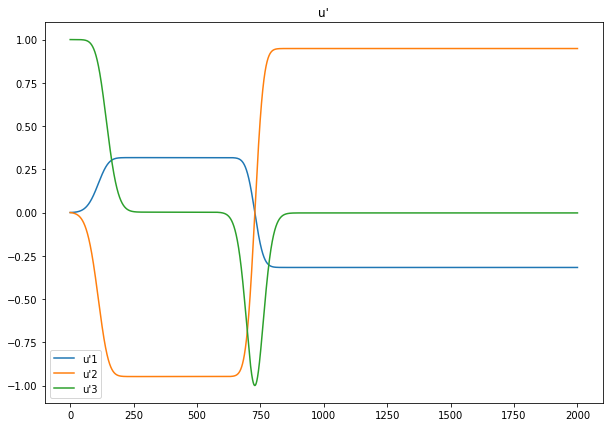

In [131]:
plt.figure(figsize=(10,7))
plt.plot(time,uprime[0],label="u'1")
plt.plot(time,uprime[1],label="u'2")
plt.plot(time,uprime[2],label="u'3")
plt.title("u'")
plt.legend()

Now we move in the original frame and we compare the results with the yambo computation. 

In [132]:
u = TLS.convertToRotatingFrame(omega,time,uprime,invert=True)

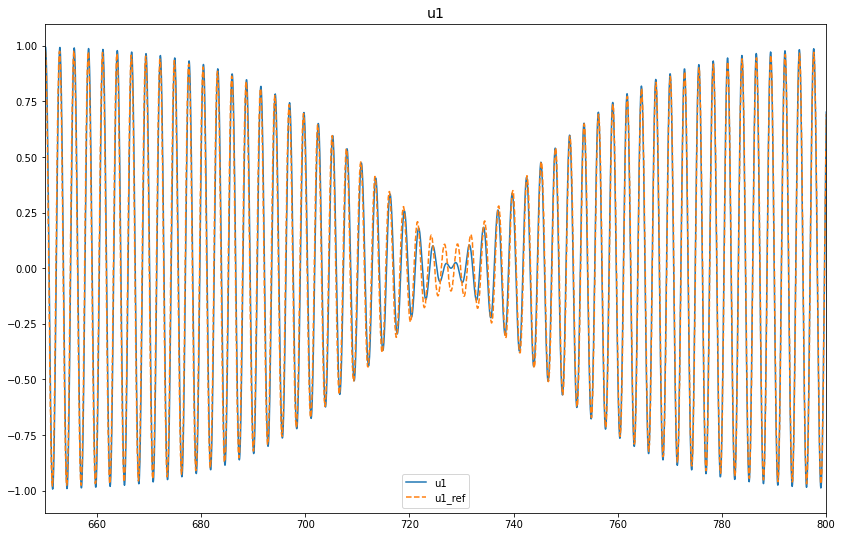

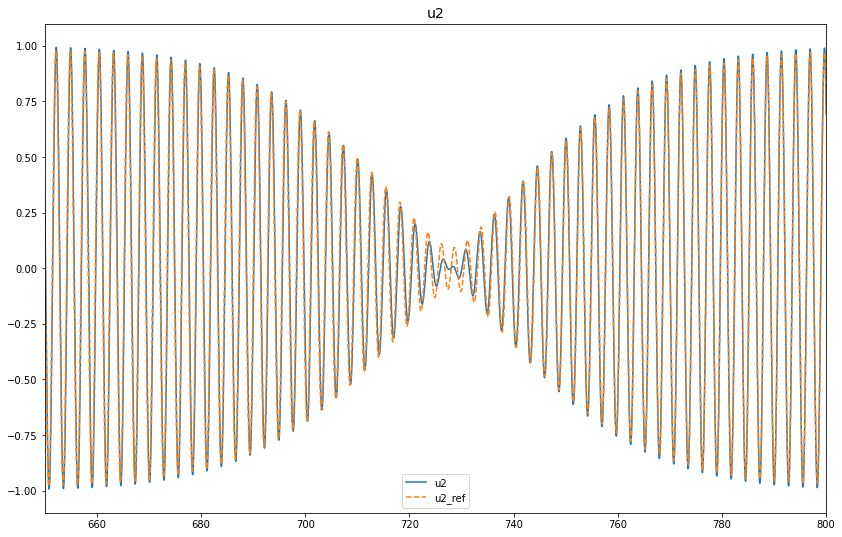

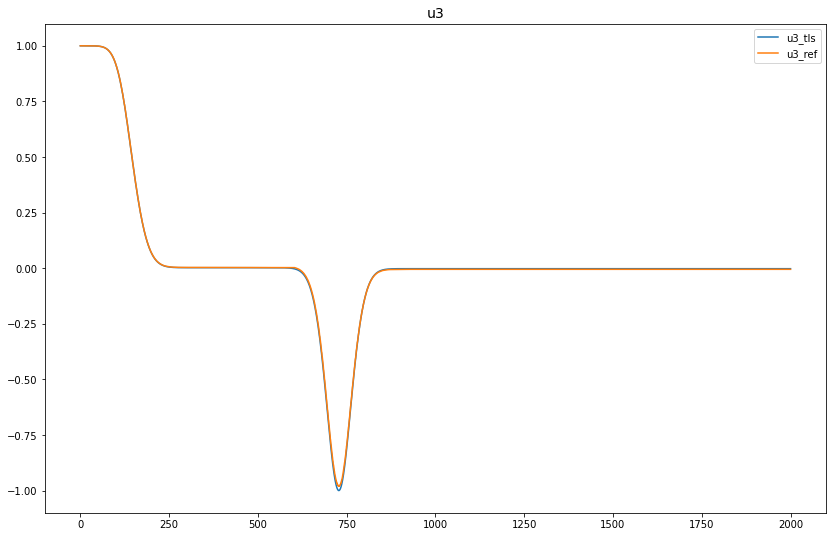

In [133]:
plt.figure(figsize=(14,9))
plt.plot(time,u[0],label='u1')
plt.plot(time,u_ref[0,:,0],linestyle='--',label='u1_ref')
plt.title('u1',size=14)
plt.xlim(650,800)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,u[1],label='u2')
plt.plot(time,u_ref[1,:,0],linestyle='--',label='u2_ref')
plt.title('u2',size=14)
plt.xlim(650,800)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.title('u3',size=14)
plt.plot(time,u[2],label='u3_tls')
plt.plot(time,u_ref[2],label='u3_ref')
plt.legend()
plt.show()

## TLS analysis of the global dynamics

We use the TLS formalism to study the dynamics due to an ensemble of k points in both the single
and double pulse configuration. We consider only a couple of valence conduction bands to use
the TLS approach.

In [3]:
fwhm = 100 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
int1 = 23758 # 23758 # # 95032 kW/cm2
int2 = 95032 # 23758 # # 95032 kW/cm2
energy = 1.5 # eV 
NETime = 4000 # fs
ntimes = 10000 #

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
omega = energy/h_red # angular frequency of the pulse

# set the tstart of the second pulse as in the RT simulation
h = C.Planck_ev_ps*1e3
period = h/energy # in fs
tstart = period*363

In [4]:
ref_run_dir = 'PHOTON_ECO/RT_k100_kspan0.04/FixSymm'
ref_outpath = 'PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans'

In [5]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans/o-echo_pi2-pi_single-trans.current
Parse file PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans/o-echo_pi2-pi_single-trans.polarization
Parse file PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans/o-echo_pi2-pi_single-trans.carriers
Parse file PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans/o-echo_pi2-pi_single-trans.external_field
Parse file : PHOTON_ECO/RT_k100_kspan0.04/FixSymm/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_k100_kspan0.04/FixSymm/echo_pi2-pi_single-trans/ndb.RT_G_PAR


In [6]:
ref_results.get_info()

YamboOutputParser variables structure
suffix current with dict_keys(['col0', 'col1', 'col2', 'col3'])
suffix polarization with dict_keys(['time', 'Pol_x', 'Pol_y', 'Pol_z'])
suffix carriers with dict_keys(['time', 'dnhmne', 'dnh', 'dne'])
suffix external_field with dict_keys(['time', 'Ex_Re', 'Ey_Re', 'Ez_Re', 'Ex_Im', 'Ey_Im', 'Ez_Im', 'Intensity', 'Fluence'])
 
YamboDipolesParser variables structure
dip_ir shape (1183, 2, 2, 3, 2)
dip_p shape (1183, 2, 2, 3, 2)
dip_v shape (1183, 2, 2, 3, 2)
dip_spin shape (1,)
 
YamboDftParser variables structure
number of k points 1183
number of bands 8
spin degeneration 1
 
YamboRTGlesserParser variables structure
Gless shape (2, 1183, 2, 2, 2)


In [7]:
# We build the reference quantities to compare with the TLS results

ref_time = ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_carriers = ref_results.data['carriers']['dne']
ref_polarization = ref_results.data['polarization']['Pol_x']

We define the array with the $x$ component of the transition dipoles and with valence-conduction
transition energies. 

From the QE analysis we know that the 50-th k points is resonant with the pump at energy 1.5 eV

In [8]:
x_dipole = ref_results.dipoles.r_dipole(0)
x_dipole[0]

array([[ 0.         +0.j        , -3.36997233-17.38215944j],
       [-3.36997233+17.38215944j,  0.         +0.j        ]])

In [9]:
numk = len(x_dipole)

In [13]:
k_ref = 50

In [14]:
de_cv = ref_results.dft.get_transitions(initial=[3],final=[4],set_scissor=scissor)[:,0]
de_cv[k_ref]

1.5000019622415341

Note that the $x_{01}$ component that is the equivalent of the $\mu_{12}$ dipole (with opposite sign!)  defined in theory of the TLS.

We compute the field amplitude and the Rabi coupling associated to a given field intensity

In [16]:
mu12_ref = -x_dipole[k_ref,0,1]
pars1 = TLS.pulseParametersFromIntensity(mu12_ref,int1,fwhm=fwhm)
pars2 = TLS.pulseParametersFromIntensity(mu12_ref,int2,fwhm=fwhm)
#pars1

time unit: fs
the width parameter of the pulse is 42.466090014400955 fs
Rabi coupling (fs^-1): (-0.004784256168179408-0.013959516680342239j)
Rabi coupling (module) (fs^-1): 0.014756598965598947
field amplitude (V/m): 9460633.581454257
pulse area : 1.5707912917853026
time unit: fs
the width parameter of the pulse is 42.466090014400955 fs
Rabi coupling (fs^-1): (-0.009568512336358815-0.027919033360684478j)
Rabi coupling (module) (fs^-1): 0.029513197931197895
field amplitude (V/m): 18921267.162908513
pulse area : 3.1415825835706053


In [17]:
time = np.linspace(0,NETime,ntimes)

We build the gaussian pulse used as input of the TLS and check that its amplitude matches the
one of the yambo Ex field

In [18]:
pulse = G.doubleGaussianPulse(time,energy=energy,amplitude1=pars1['field_amplitude'],fwhm1=fwhm,
                amplitude2=pars2['field_amplitude'],fwhm2=fwhm,t_start2=tstart)

time unit: fs - energy unit: eV
period of the oscillations 2.757111798154881 fs
width of the first pulse 42.466090014400955 fs
fwhm of the first pulse 100 fs
width of the second pulse 42.466090014400955 fs
fwhm of the second pulse 100 fs


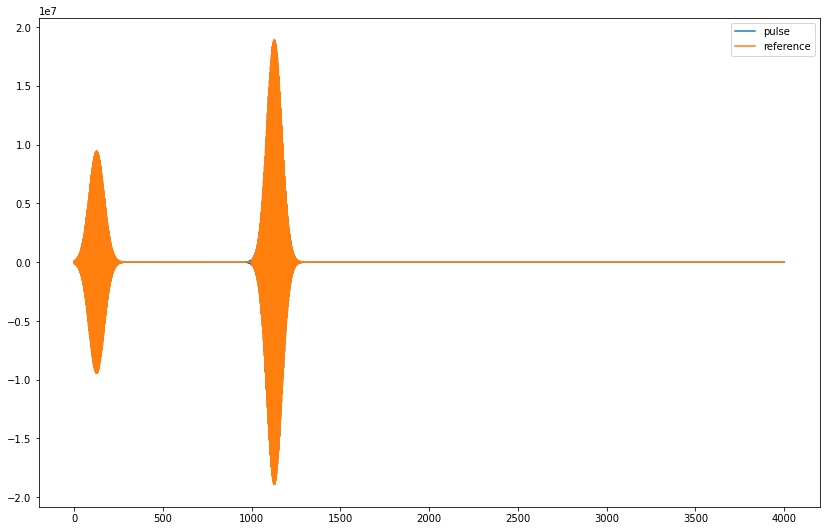

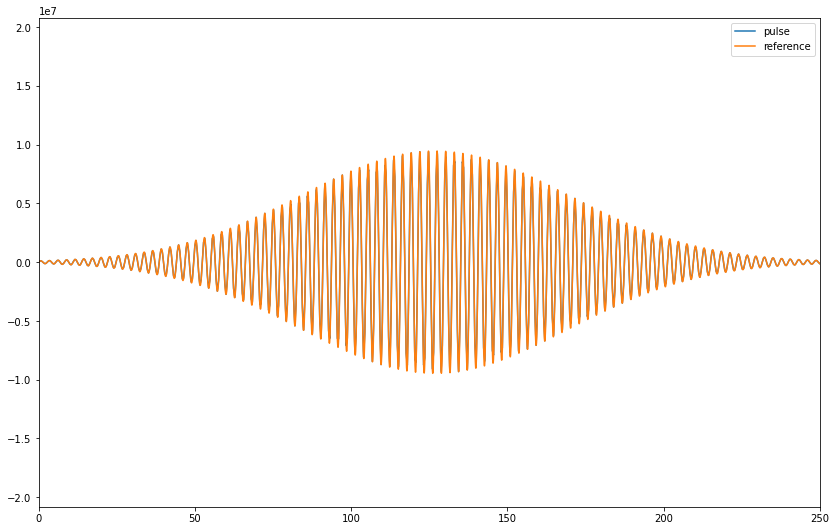

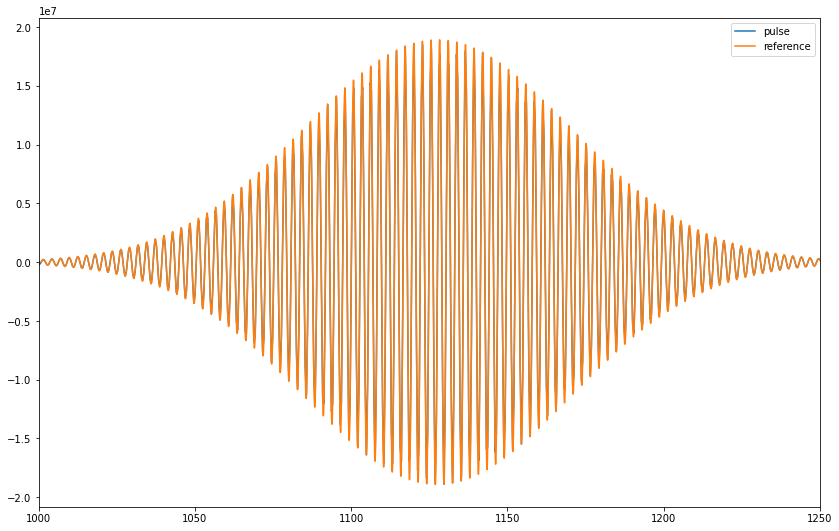

In [19]:
plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(0,250)
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(1000,1250)
plt.show()

We solve the Bloch equations for each k point

In [20]:
delta = omega - de_cv/h_red

In [21]:
uprime = np.zeros([3,ntimes,numk])
u = np.zeros([3,ntimes,numk])

for k in range(numk):
    uprime0 = np.array([0.,0.,1.])
    mu12 = -x_dipole[k,0,1]
    Omega0_abs1 = TLS.pulseParametersFromIntensity(mu12,int1,fwhm=fwhm,verbose=False)['Omega0_abs']
    Omega0_abs2 = TLS.pulseParametersFromIntensity(mu12,int2,fwhm=fwhm,verbose=False)['Omega0_abs']
    Omega = lambda t : G.doubleGaussianPulse(t,energy=energy,amplitude1=Omega0_abs1,fwhm1=fwhm, \
                amplitude2=Omega0_abs2,fwhm2=fwhm,t_start2=tstart,envelope_only=True,verbose=False)
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta[k])

for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

We look for the signal of the echo mechanism directly at the level of the Bloch vectors. 

To do so we convert the vector in the $x$ basis and plot the average vector due to all the
k points.

In [45]:
x_global = np.zeros([3,ntimes])
for k in range(numk):
    x_global += TLS.convertToXbasis(uprime[:,:,k],mu12=x_dipole[k,0,1])/numk

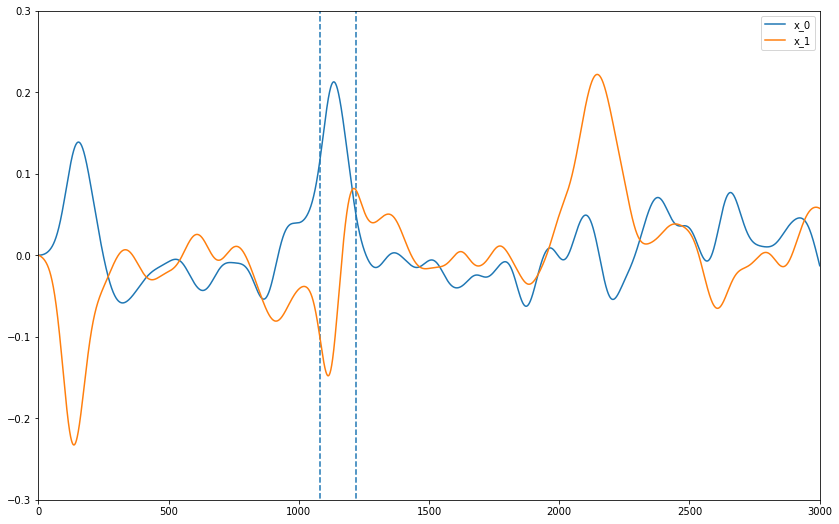

In [67]:
plt.figure(figsize=(14,9))
plt.plot(time,x_global[0],label='x_0')
plt.plot(time,x_global[1],label='x_1')
plt.vlines(1080,-1,1,linestyles='--')
plt.vlines(1220,-1,1,linestyles='--')
plt.xlim(0,3000)
plt.ylim(-0.3,0.3)
plt.legend()

Note that the average $y$ component changes sign during the echo pulse, while the $x$ components at the
end of the pulse does not change. This is in agreement with the expected behavior computed through the 
Bloch equations (negleting the detuning during the pulse regime). Due to this fact the $y$ component shows
the echo signal at $t \simeq 2100$ when all the addends are again in phase

Now we discuss the echo at the level of the observables.

We compute the carriers and the polarization and compare with the yambo results

In [60]:
carriers = 1 - np.mean(u[2],axis=1)

lat_vol = ref_results.dft.eval_lattice_volume()
Rx10 = -x_dipole[:,1,0].real
Ix10 = -x_dipole[:,1,0].imag
Polx_k_Bloch = 2*(u[0]*Rx10+u[1]*Ix10) # factor 2 for the spin degeneration
#Polx_k_Bloch = 2*(uprime[0]*Rx10+uprime[1]*Ix10) # factor 2 for the spin degeneration
Polx_Bloch = np.mean(Polx_k_Bloch,axis=1)
Polx_Bloch /= lat_vol

(0.0, 0.5)

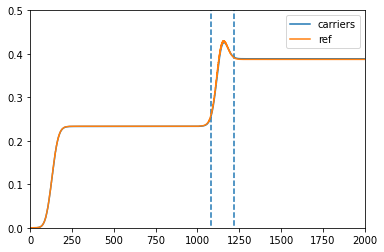

In [66]:
plt.plot(time,carriers,label='carriers')
plt.plot(ref_time,ref_carriers,label='ref')
plt.vlines(1080,-1,1,linestyles='--')
plt.vlines(1220,-1,1,linestyles='--')
plt.legend()
plt.xlim(0,2000)
plt.ylim(0,0.5)

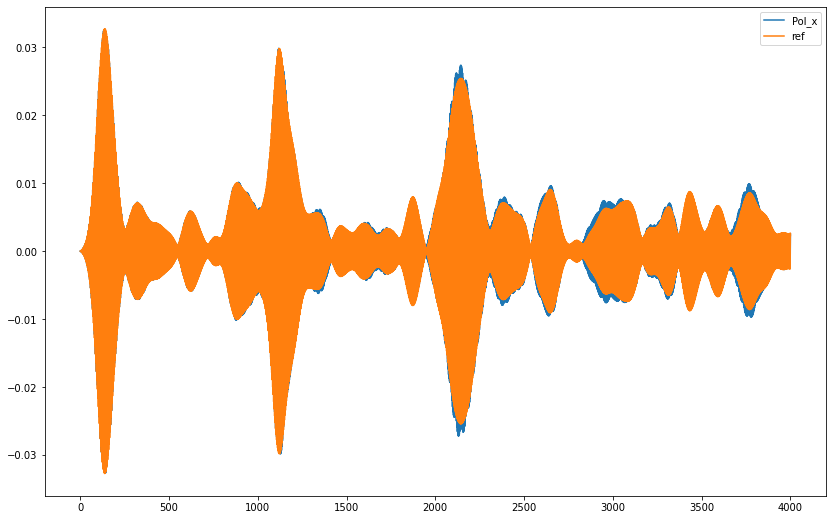

In [62]:
plt.figure(figsize=(14,9))
plt.plot(time,Polx_Bloch,label='Pol_x')
plt.plot(ref_time,ref_polarization,label='ref')
plt.legend()

The TLS is able to reproduce the yambo results and the echo signal is clearly visible.

Indeed if the echo pulse is absent the time dynamics becomes

In [27]:
uprime_sp = np.zeros([3,ntimes,numk])
u_sp = np.zeros([3,ntimes,numk])

for k in range(numk):
    uprime0 = np.array([0.,0.,1.])
    mu12 = -x_dipole[k,0,1]
    Omega0_abs1 = TLS.pulseParametersFromIntensity(mu12,int1,fwhm=fwhm,verbose=False)['Omega0_abs']
    Omega0_abs2 = 0
    Omega = lambda t : G.doubleGaussianPulse(t,energy=energy,amplitude1=Omega0_abs1,fwhm1=fwhm, \
                amplitude2=Omega0_abs2,fwhm2=fwhm,t_start2=tstart,envelope_only=True,verbose=False)
    uprime_sp[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta[k])

for k in range(numk):
    u_sp[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime_sp[:,:,k],invert=True)

In [32]:
#Polx_k_Bloch_sp = 2*(uprime_sp[0]*Rx10+uprime_sp[1]*Ix10) # factor 2 for the spin degeneration
Polx_k_Bloch_sp = 2*(u_sp[0]*Rx10+u_sp[1]*Ix10) # factor 2 for the spin degeneration
Polx_Bloch_sp = np.mean(Polx_k_Bloch_sp,axis=1)
Polx_Bloch_sp /= lat_vol

(0.0, 1000.0)

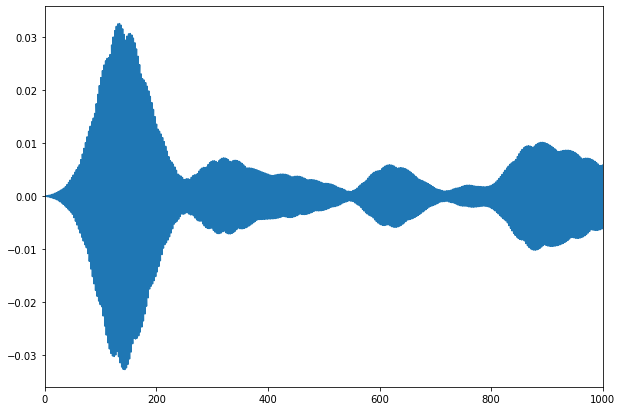

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(time,Polx_Bloch_sp)
plt.xlim(0,1000)

### Critical analysis on the possibilty of the echo mechanism

Now we try to check which are the conditions that have allowed the spin echo in this case.


In [174]:
min(delta),max(delta)

(-0.06106261453681805, 0.12148977523387083)

In [196]:
delta_dos = U.Dos()
delta_dos.append(delta,minVal=-0.3,maxVal=0.4,eta=1e-2)

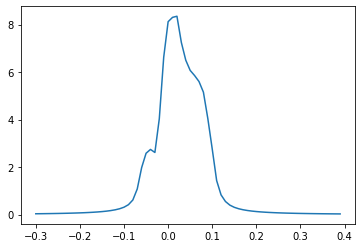

In [198]:
delta_dos.plot(plt,legend=False)

In [201]:
delta[0],delta[1],delta[2]

(0.12148977523387083, 0.0886686872635889, -0.004969010264845419)

In [214]:
indt0 = np.where(time > 1000)[0][0]
indtf = np.where(time > 1300)[0][0]
time[indt0],time[indtf]

(1000.1000100010001, 1300.1300130013)

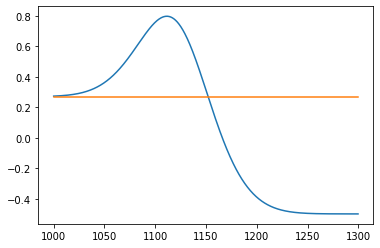

In [236]:
k = 9
comp = 2
x = TLS.convertToXbasis(uprime[:,:,k],mu12=x_dipole[k,0,1])
x_sp = TLS.convertToXbasis(uprime_sp[:,:,k],mu12=x_dipole[k,0,1])
plt.plot(time[indt0:indtf],x[comp,indt0:indtf])
plt.plot(time[indt0:indtf],x_sp[comp,indt0:indtf])

(0.0, 500.0)

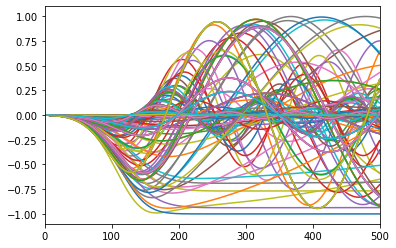

In [242]:
comp = 1
for k in range(150):
    x = TLS.convertToXbasis(uprime[:,:,k],mu12=x_dipole[k,0,1])
    plt.plot(time,x[comp])
plt.xlim(0,500)
    